# **UNET_EDGE_DETECTOR**



The objective of the model is to create an edge map of an input image. For which I have used a U-Net model because this work is very similar to semantuc segmentation as we are classifing each pixel to a catecory edge(1) or non-edge(0).So it is intutive to get a consized feature reprsentation of the image and then reconstructing an edge map by upsampoling these feature and for a better information flow we have residual conection between freature during down sampling and up sampling.

In [1]:
# Importing required libraries
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import os
from PIL import Image, ImageOps
import cv2
from tensorflow.keras import layers

In [2]:
from google.colab import drive

mountpoint="/content/gdrive"
Datadir=os.path.join(mountpoint,"UNET_EDGE_DETECTOR")
drive.mount(mountpoint)

Mounted at /content/gdrive


In [3]:
# Hyper Parameters
batch=32
im_h=512
im_w=512

# Input Pipeline

In [4]:
# LOADING TRAIN DATA
train_x=tf.keras.utils.image_dataset_from_directory(r"/content/gdrive/MyDrive/UNET_EDGE_DETECTOR/Dataset/train/train_x",labels= None,label_mode='int',class_names="train_x", color_mode='rgb',batch_size=batch,image_size=(im_h, im_w),shuffle=False)
train_y=tf.keras.utils.image_dataset_from_directory(r"/content/gdrive/MyDrive/UNET_EDGE_DETECTOR/Dataset/train/train_y",labels= None,label_mode='int',class_names="train_y", color_mode='grayscale',batch_size=batch,image_size=(im_h,im_w),shuffle=False)


Found 200 files belonging to 1 classes.
Found 200 files belonging to 1 classes.


In [5]:
X=[]

for img in train_x:
    for i in img :
     X.append(i)
X=tf.convert_to_tensor(X)


Y=[]

for img in train_y:
    for i in img :
     Y.append(i[:,:,0])
     
Y=tf.convert_to_tensor(Y)
Y=tf.expand_dims(Y,-1)



    

In [6]:
dataset=tf.data.Dataset.from_tensor_slices({"pixel_values":X, "labels":Y})


In [7]:
dataset.element_spec

{'pixel_values': TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None),
 'labels': TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None)}

# Preprocessing

Since the ground truth edge map has value of pixel in range of 0 to 255 but for training purpose i need a labeled mask for each pixel as 1 or 0 so that is implemented here.Also image augumentation is applied to encrease training set and making model more robust.

In [8]:
def preprocess(data):
  image = data["pixel_values"]
  label=data["labels"]
  # NORMALISATION
  image = (image / 255.0)
  label= (label/255.0)
  # converting edge map to 0 and 1 mask
  label=(label>0.5)
  label=tf.cast(label,dtype=float)
  return image,label


def augument(data):
  image,label= preprocess(data)
  if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       image = tf.image.flip_left_right(image)
       label = tf.image.flip_left_right(label)

  return image, label

In [9]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (
    dataset
    .map(augument, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    
)

(-0.5, 511.5, 511.5, -0.5)

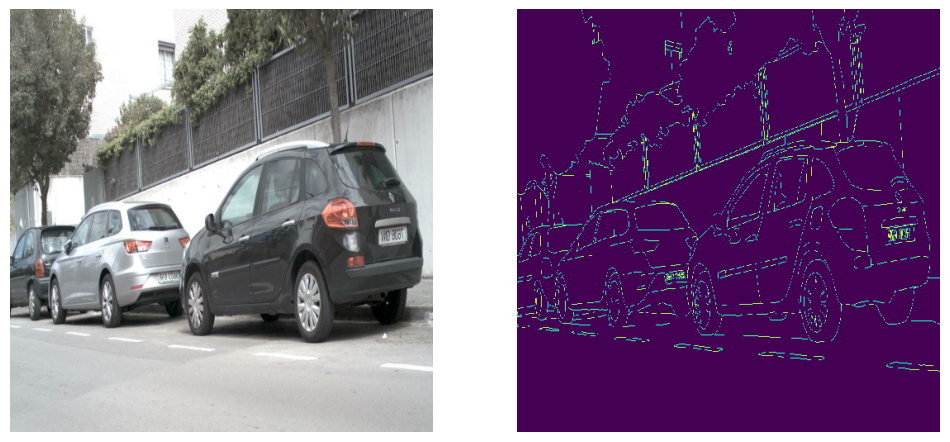

In [10]:
from matplotlib import pyplot as plt

for img,label in train_ds:
    im=tf.keras.utils.array_to_img(img[0])
    lab=tf.keras.utils.array_to_img(label[0])
    break


fig = plt.figure(figsize=(12, 7))
rows,columns = 1,2

fig.add_subplot(rows, columns, 1)
plt.imshow(im)
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(lab)
plt.axis('off')

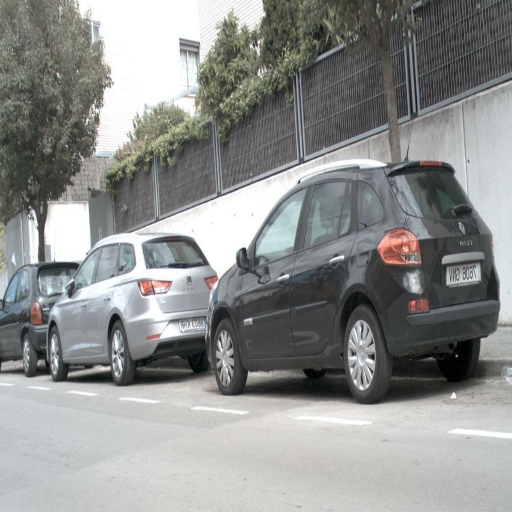

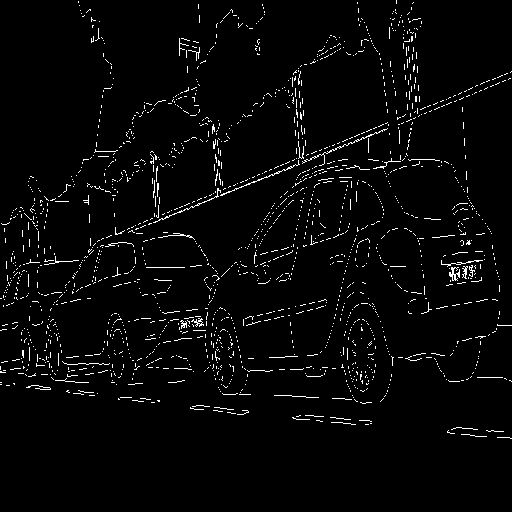

In [11]:
im.show()
lab.show()

# Validation Dataset

In [12]:
val_x=tf.keras.utils.image_dataset_from_directory(r"/content/gdrive/MyDrive/UNET_EDGE_DETECTOR/Dataset/val_x",labels= None,label_mode='int',class_names="val_x", color_mode='rgb',batch_size=batch,image_size=(im_h, im_w),shuffle=False)
val_y=tf.keras.utils.image_dataset_from_directory(r"/content/gdrive/MyDrive/UNET_EDGE_DETECTOR/Dataset/val_y",labels= None,label_mode='int',class_names="val_y", color_mode='grayscale',batch_size=batch,image_size=(im_h,im_w),shuffle=False)


Found 30 files belonging to 1 classes.
Found 30 files belonging to 1 classes.


In [13]:
val_X=[]

for img in val_x:
    for i in img :
     val_X.append(i)
val_X=tf.convert_to_tensor(val_X)


val_Y=[]

for img in val_y:
    for i in img :
     val_Y.append(i[:,:,0])
     
val_Y=tf.convert_to_tensor(val_Y)
val_Y=tf.expand_dims(val_Y,-1)

val_dataset=tf.data.Dataset.from_tensor_slices({"pixel_values":val_X, "labels":val_Y})



AUTOTUNE = tf.data.AUTOTUNE
val_ds = (
    val_dataset
    .map(preprocess, num_parallel_calls=AUTOTUNE)  
    .batch(30)
)

In [14]:
val_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>

## MODEL

Here I have used pretrained vgg19 network as the encoder of U-Net because on training from scratch on a small dataset leads to overfitting and poor performance. This network is trained on imagenet so mjust have learned low level features to get insight and context of image which can be used as baseline for our model as well obver which we can then further finetune the model.

In [15]:

from tensorflow.keras.applications.vgg19 import VGG19
base_model=tf.keras.applications.vgg19.VGG19(include_top=False,input_shape=(512,512,3),weights='imagenet')

In [16]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [17]:
base_model= tf.keras.Model([base_model.input],[base_model.get_layer('block4_conv2').output])

In [18]:
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [19]:
def conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = tf.keras.layers.BatchNormalization()(x)  
   return x

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D with ReLU activation
   x = conv_block(x, n_filters)
   return x


  

# UNET MODEL WITH VGG19 ECODER

In [20]:
# UNET MODEL WITH VGG19 AS ENCODER

set_trainable = False
for layer in base_model.layers:
  if layer.name in ['block1_conv1']:
        set_trainable = True

inputs= base_model.input
last_layer = base_model.output
bottle_neck=conv_block(last_layer,512)
u1=upsample_block(bottle_neck,base_model.get_layer("block3_conv4").output,256)
u2=upsample_block(u1,base_model.get_layer("block2_conv2").output,128)
u3=upsample_block(u2,base_model.get_layer("block1_conv2").output,64)
outputs= layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u3)
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
unet_model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

**NOTE: Since training was not possible by the colab resources  I have trained the model on my instiututes param ganga server and here I am loading that trained weight**

In [21]:
unet_model.load_weights('/content/gdrive/MyDrive/UNET_EDGE_DETECTOR/my_checkpoint_unet')

# **Coustom Loss Function**

The most crucial part of this model is the loss function as using BinaryCross Entropy loss fails here because class are highly imbalanced so model learns to cheat and just perform well in classifing non edge pixels correctly. And hence assign all the pixel as non edge beacuse it alone reduces the loss function drasticall y as these pixel have high contribution in loss. 

**Loss Function:**  **-**(Beta)*(y_true)*(log(y_pred))-(1-Beta)*(1-y_true)*(log(1-y_pred))

**Beta** = (Total Number of Edge Pixel)/(Total Number of Pixel in Image)



By dyamically weighting the loss for every image we bring the contribution of edge and non edge classification to the same order so model will learn to perform well on both the classification and will not give a biased output.

In [22]:
import tensorflow.keras.backend as K
class cross_entropy_balanced(tf.keras.losses.Loss):
  def __init__(self, name="custom_mse"):
        super().__init__(name=name)


  def call(self,y_true, y_pred):
    

    y_pred   = tf.clip_by_value(y_pred,K.epsilon(), 1 - K.epsilon())

    y_true = tf.cast(y_true, tf.float32) 
    img_cost=0
    
    
    count_neg = tf.math.reduce_sum(1. - y_true,[1,2,3])
    count_pos = tf.math.reduce_sum(y_true,[1,2,3])
    beta=count_pos / (count_neg + count_pos)
    pr_1=-tf.multiply(y_true,tf.math.log(y_pred))
    pr_0=-tf.multiply((1.-y_true),tf.math.log(1.-y_pred))
    img_cost=(beta*tf.math.reduce_sum(pr_0,[1,2,3]))+((1-beta)*tf.math.reduce_sum(pr_1,[1,2,3]))
    img_cost=tf.math.reduce_sum(img_cost)
     

    return img_cost

In [23]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                  loss=cross_entropy_balanced(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(threshold=(0.68)),tf.keras.metrics.Precision(thresholds=(0.68)),tf.keras.metrics.Recall(thresholds=(0.68))])

In [24]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
       
        # The saved model name will include the current epoch.
        filepath="./checkpoints/my_checkpoint_unet",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]

**NOTE: Since training was not possible by the colab resources  I have trained the model on my instiututes param ganga server and here I am loading that trained weight**

In [ ]:
NUM_EPOCHS = 15
history=unet_model.fit(train_ds,epochs=NUM_EPOCHS,callbacks=callbacks,validation_data=val_ds,shuffle=False)

In [25]:
check_x=[]
check_y=[]

for img,label in train_ds:
    for i in img :
     check_x.append(i)
     break
    for i in label :
     check_y.append(i)
     break
check_x=tf.convert_to_tensor(check_x)
check_y=tf.convert_to_tensor(check_y)


In [26]:
check_x.shape

TensorShape([7, 512, 512, 3])

In [27]:

fin_out= unet_model.predict(check_x)



1/1 [==============================] - 47s 47s/step


In [28]:
fin_out.shape

(7, 512, 512, 1)

Text(0.5, 1.0, 'Prediction')

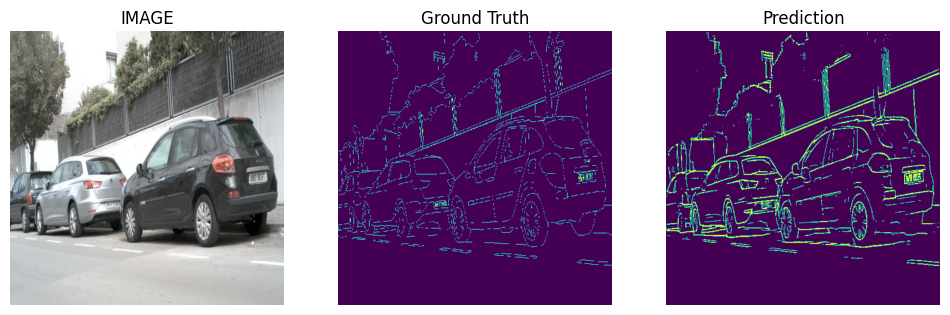

In [35]:
from matplotlib import pyplot as plt

im=tf.keras.utils.array_to_img(check_x[0])
lab=tf.keras.utils.array_to_img(check_y[0])


output=tf.keras.utils.array_to_img(fin_out[0]>0.75)

fig = plt.figure(figsize=(12, 7))
rows,columns = 1,3

fig.add_subplot(rows, columns, 1)
plt.imshow(im)
plt.axis('off')
plt.title("IMAGE")
fig.add_subplot(rows, columns, 2)
plt.imshow(lab)
plt.axis('off')
plt.title("Ground Truth")

fig.add_subplot(rows, columns, 3)
plt.imshow(output)
plt.axis('off')
plt.title("Prediction")

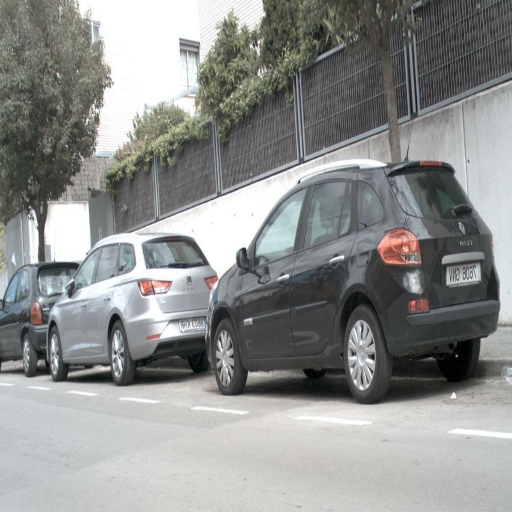

In [30]:
fi=tf.keras.utils.array_to_img(check_x[0])
fi.show()

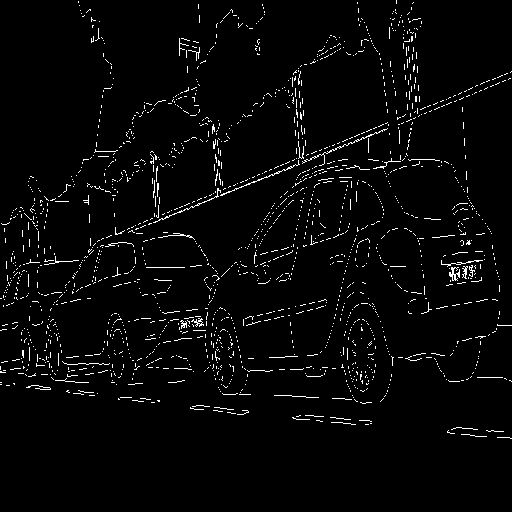

In [31]:
fi=tf.keras.utils.array_to_img(check_y[0])
fi.show()

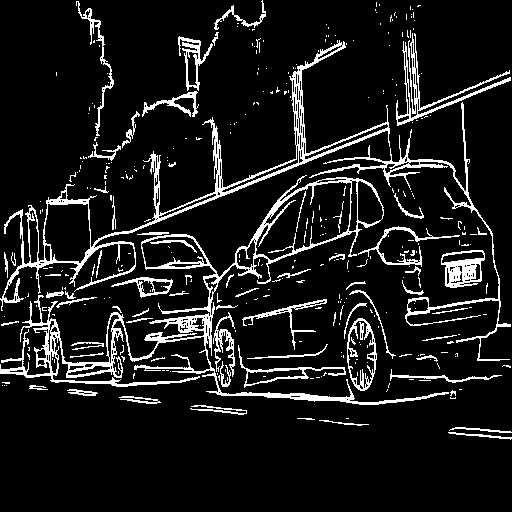

In [32]:
fi=tf.keras.utils.array_to_img(fin_out[0]>0.68)
fi.show()

In [33]:
result = unet_model.evaluate(val_ds)


1/1 [==============================] - 206s 206s/step - loss: 188352.5625 - binary_accuracy: 0.9120 - precision: 0.2125 - recall: 0.6973


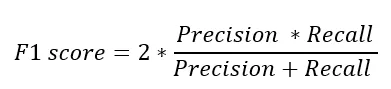

# **RESULT**


**F1 SCORE ON VALIDATION DATASET IS 0.326**